In [1]:
from PIL import Image ## To import and resize the image
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Flatten,Dense,LSTM,GRU
from keras.utils.np_utils import to_categorical
#from tensorflow.optimizers import Adam
from sklearn.model_selection import train_test_split
import itertools
import tensorflow as tf
from keras import regularizers
from keras.callbacks import EarlyStopping

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026412.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000

In [3]:
## Loading the meta data dataset that contains the classification labels and the target images
df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df.sample(10)
## Checking for missing values
df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [4]:
## Fill the ages with mean values of age
df.loc[:,'age'].fillna(df.loc[:,'age'].mean(),inplace=True)
df.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [5]:
## Checking the distribution of the labels
pd.DataFrame(df['dx'].value_counts())

,dx
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


In [6]:
# Mapping the lesions 
lesion_mapping = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [7]:
from glob import glob
import os
base_dir = os.path.join('..','input/skin-cancer-mnist-ham10000')

imageid_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

In [8]:
## Reading and processing the data

df['paths_id'] = df['image_id'].map(imageid_path.get)
df['cell_type'] = df['dx'].map(lesion_mapping.get)
df['label'] = pd.Categorical(df['cell_type']).codes
df['image_array']=df['paths_id'].map(lambda x: np.asarray(Image.open(x).resize((125,100))))
X = np.asarray(df['image_array'].tolist())
y = np.asarray(df['label'].tolist())
y = to_categorical(y,num_classes=7)
X_train,X_val_test,y_train,y_val_test = train_test_split(X,y,train_size=0.9,random_state=23)
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)

X_val_test_mean = np.mean(X_val_test)
X_val_test_std = np.std(X_val_test)

X_train = (X_train - X_train_mean)/X_train_std
X_val_test = (X_val_test - X_val_test_mean)/X_val_test_std
X_test,X_val,y_test,y_val = train_test_split(X_val_test,y_val_test,train_size=0.5,random_state=23)
print("X_train shape before reshaping {}".format(X_train.shape))
print("X_test shape before reshaping {}".format(X_test.shape))
print("X_val shape before reshaping {}".format(X_val.shape))
print("\n Y_test shape before reshaping {}".format(y_test.shape))
print("Y_val shape before reshaping {}".format(y_val.shape))
X_train = X_train.reshape(X_train.shape[0], *(100, 125*3))
X_test = X_test.reshape(X_test.shape[0], *(100, 125*3))
X_val = X_val.reshape(X_val.shape[0], *(100, 125*3))
print("X_train shape after reshaping {}".format(X_train.shape))
print("X_test shape after reshaping {}".format(X_test.shape))
print("X_val shape after reshaping {}".format(X_val.shape))
print("\n Y_test shape after reshaping {}".format(y_test.shape))
print("Y_val shape after reshaping {}".format(y_val.shape))

X_train shape before reshaping (9013, 100, 125, 3)
X_test shape before reshaping (501, 100, 125, 3)
X_val shape before reshaping (501, 100, 125, 3)

 Y_test shape before reshaping (501, 7)
Y_val shape before reshaping (501, 7)
X_train shape after reshaping (9013, 100, 375)
X_test shape after reshaping (501, 100, 375)
X_val shape after reshaping (501, 100, 375)

 Y_test shape after reshaping (501, 7)
Y_val shape after reshaping (501, 7)


In [9]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
def plot_val_loss(history):
    history_dict = history.history
    loss_value = history_dict['loss']
    val_loss_value = history_dict['val_loss']
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    epochs = range(1, len(loss_value) + 1)
    plt.plot(epochs, loss_value, 'b', label='Training Loss')
    plt.plot(epochs, val_loss_value, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    plt.figure()

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation acuuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()

    plt.show()

def display_confusion_matrix(actual, pred):
    (tn, fp), (fn, tp) = confusion_matrix(actual, pred)
    print('-----------Confusion Matrix------------')
    print(f'True Positives = {tp} \t True Negatives = {tn}',
         f'\nFale Negatives = {fn} \t False Positives = {fp}')
    print('=======================================')
    print(f'Accuracy = {(tp+tn) / (tp+fn+tn+fp)}')
    
def model_evaluate(model):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    loss_v, accuracy_v = model.evaluate(X_val, y_val, verbose=1)
    print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
    print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))


In [10]:
# Model with 2 GRU and 2 Dense layers without any regularization and adam optimizer:-
GRU1 = Sequential()
GRU1.add(GRU(32,input_shape = (9013,375),return_sequences = True))
GRU1.add(GRU(32))
GRU1.add(Flatten())
GRU1.add(Dense(16,activation = 'relu'))
GRU1.add(Dense(7,activation = 'softmax',name = 'Output'))
GRU1.summary()
GRU1.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])
# Fit the model
epochs = 25
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=4)
history1 = GRU1.fit(X_train,y_train,epochs = epochs,validation_data = (X_val,y_val),
                          batch_size = 128,callbacks = [callbacks])
model_evaluate(GRU1)

2023-02-02 11:21:57.567526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 11:21:57.686934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 11:21:57.688249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 11:21:57.690529: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 9013, 32)          39264     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
Output (Dense)               (None, 7)                 119       
Total params: 46,247
Trainable params: 46,247
Non-trainable params: 0
_________________________________________________________________


2023-02-02 11:22:01.422402: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1351950000 exceeds 10% of free system memory.
2023-02-02 11:22:02.955049: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1351950000 exceeds 10% of free system memory.
2023-02-02 11:22:04.046556: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2023-02-02 11:22:07.393575: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


71/71 [==============================] - 7s 30ms/step - loss: 1.1885 - accuracy: 0.6534 - val_loss: 1.1294 - val_accuracy: 0.6407
Epoch 2/25
71/71 [==============================] - 1s 19ms/step - loss: 1.0147 - accuracy: 0.6697 - val_loss: 1.0751 - val_accuracy: 0.6427
Epoch 3/25
71/71 [==============================] - 1s 18ms/step - loss: 0.9634 - accuracy: 0.6760 - val_loss: 1.0291 - val_accuracy: 0.6507
Epoch 4/25
71/71 [==============================] - 1s 19ms/step - loss: 0.9127 - accuracy: 0.6863 - val_loss: 0.9924 - val_accuracy: 0.6567
Epoch 5/25
71/71 [==============================] - 1s 21ms/step - loss: 0.8645 - accuracy: 0.6926 - val_loss: 0.9488 - val_accuracy: 0.6567
Epoch 6/25
71/71 [==============================] - 1s 18ms/step - loss: 0.8147 - accuracy: 0.7134 - val_loss: 0.9181 - val_accuracy: 0.6846
Epoch 7/25
71/71 [==============================] - 1s 18ms/step - loss: 0.7798 - accuracy: 0.7221 - val_loss: 0.9162 - val_accuracy: 0.6567
Epoch 8/25
71/71 [======

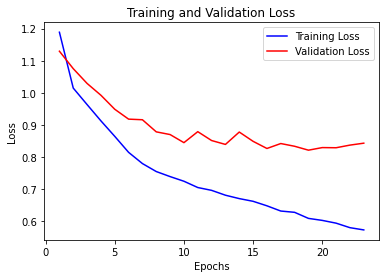

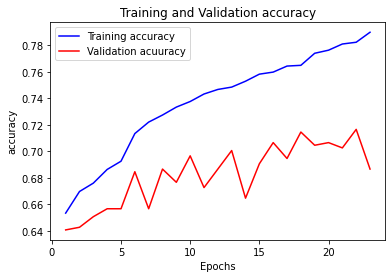

In [11]:
plot_val_loss(history1)
GRU1.save("GRU_non_regularization_adam.h5")

In [12]:
# Model with 2 GRU and 2 Dense with regularization with optimizer adam:-(Dropout layers and L2 regularizer)
GRU2 = Sequential()
GRU2.add(GRU(32,input_shape = (9013,375),return_sequences = True,kernel_regularizer = regularizers.l2(0.0001)))
GRU2.add(Dropout(0.25))
GRU2.add(GRU(32,kernel_regularizer = regularizers.l2(0.0001)))
GRU2.add(Flatten())
GRU2.add(Dense(16,activation = 'relu',kernel_regularizer = regularizers.l2(0.0001)))
GRU2.add(Dropout(0.25))
GRU2.add(Dense(7,activation = 'softmax',name = 'Output'))
GRU2.summary()
#compile the model
GRU2.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])
# Fit the model
epochs = 25
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=4)
history2 = GRU2.fit(X_train,y_train,epochs = epochs,validation_data = (X_val,y_val),
                          batch_size = 128,callbacks = [callbacks])
model_evaluate(GRU2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 9013, 32)          39264     
_________________________________________________________________
dropout (Dropout)            (None, 9013, 32)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                6336      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
Output (Dense)               (None, 7)                

2023-02-02 11:22:44.103382: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1351950000 exceeds 10% of free system memory.
2023-02-02 11:22:45.662538: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1351950000 exceeds 10% of free system memory.


Epoch 1/25
71/71 [==============================] - 5s 29ms/step - loss: 1.3228 - accuracy: 0.5742 - val_loss: 1.1658 - val_accuracy: 0.6427
Epoch 2/25
71/71 [==============================] - 1s 21ms/step - loss: 1.1448 - accuracy: 0.6522 - val_loss: 1.1054 - val_accuracy: 0.6407
Epoch 3/25
71/71 [==============================] - 1s 19ms/step - loss: 1.0553 - accuracy: 0.6649 - val_loss: 1.0332 - val_accuracy: 0.6467
Epoch 4/25
71/71 [==============================] - 1s 19ms/step - loss: 0.9778 - accuracy: 0.6746 - val_loss: 0.9673 - val_accuracy: 0.6507
Epoch 5/25
71/71 [==============================] - 1s 18ms/step - loss: 0.9176 - accuracy: 0.6816 - val_loss: 0.9401 - val_accuracy: 0.6687
Epoch 6/25
71/71 [==============================] - 1s 19ms/step - loss: 0.8915 - accuracy: 0.6838 - val_loss: 0.9499 - val_accuracy: 0.6687
Epoch 7/25
71/71 [==============================] - 1s 18ms/step - loss: 0.8673 - accuracy: 0.7015 - val_loss: 0.9253 - val_accuracy: 0.6727
Epoch 8/25
71

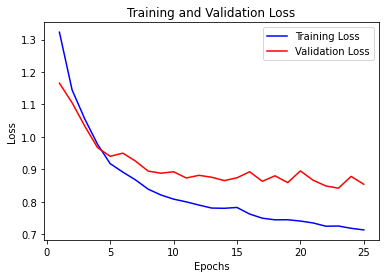

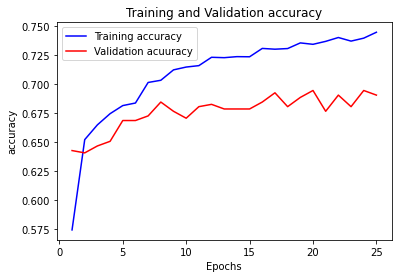

In [13]:
plot_val_loss(history2)
GRU2.save("GRU_regularization_adam.h5")

In [14]:
# Model with 2 GRU and 2 Dense with regularization with optimizer rmsprop:-(Dropout layers and L2 regularizer)
GRU3 = Sequential()
GRU3.add(GRU(32,input_shape = (9013,375),return_sequences = True,kernel_regularizer = regularizers.l2(0.0001)))
GRU3.add(Dropout(0.25))
GRU3.add(GRU(32,kernel_regularizer = regularizers.l2(0.0001)))
GRU3.add(Flatten())
GRU3.add(Dense(16,activation = 'relu',kernel_regularizer = regularizers.l2(0.0001)))
GRU3.add(Dropout(0.25))
GRU3.add(Dense(7,activation = 'softmax',name = 'Output'))
GRU3.summary()
#compile the model
GRU3.compile(optimizer = 'rmsprop' , loss = "categorical_crossentropy", metrics=["accuracy"])
# Fit the model
epochs = 25
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=4)
history3 = GRU3.fit(X_train,y_train,epochs = epochs,validation_data = (X_val,y_val),
                          batch_size = 128,callbacks = [callbacks])
model_evaluate(GRU3)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 9013, 32)          39264     
_________________________________________________________________
dropout_2 (Dropout)          (None, 9013, 32)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 32)                6336      
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
Output (Dense)               (None, 7)                

2023-02-02 11:23:28.419659: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1351950000 exceeds 10% of free system memory.


Epoch 1/25
71/71 [==============================] - 5s 30ms/step - loss: 1.3359 - accuracy: 0.5656 - val_loss: 1.1631 - val_accuracy: 0.6347
Epoch 2/25
71/71 [==============================] - 1s 21ms/step - loss: 1.1147 - accuracy: 0.6606 - val_loss: 1.0851 - val_accuracy: 0.6447
Epoch 3/25
71/71 [==============================] - 1s 19ms/step - loss: 1.0251 - accuracy: 0.6688 - val_loss: 1.0500 - val_accuracy: 0.6527
Epoch 4/25
71/71 [==============================] - 1s 19ms/step - loss: 0.9724 - accuracy: 0.6739 - val_loss: 0.9875 - val_accuracy: 0.6647
Epoch 5/25
71/71 [==============================] - 1s 19ms/step - loss: 0.9286 - accuracy: 0.6833 - val_loss: 0.9781 - val_accuracy: 0.6727
Epoch 6/25
71/71 [==============================] - 1s 19ms/step - loss: 0.8927 - accuracy: 0.6914 - val_loss: 0.9817 - val_accuracy: 0.6627
Epoch 7/25
71/71 [==============================] - 1s 18ms/step - loss: 0.8728 - accuracy: 0.6983 - val_loss: 0.9148 - val_accuracy: 0.6747
Epoch 8/25
71

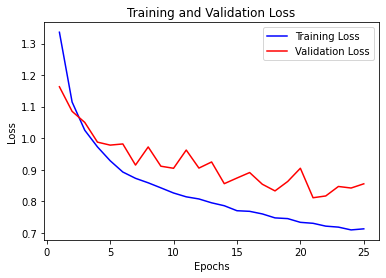

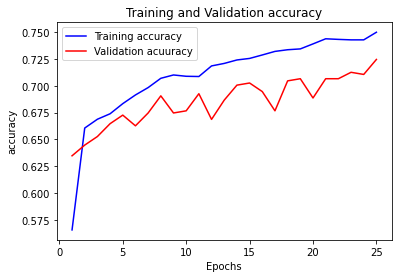

In [15]:
plot_val_loss(history3)
GRU3.save("GRU_regularization_rmsprop.h5")

In [16]:
# Model with 2 GRU and 2 Dense with regularization with optimizer SGD:-(Dropout layers and L2 regularizer)
GRU4 = Sequential()
GRU4.add(GRU(32,input_shape = (9013,375),return_sequences = True,kernel_regularizer = regularizers.l2(0.0001)))
GRU4.add(Dropout(0.25))
GRU4.add(GRU(32,kernel_regularizer = regularizers.l2(0.0001)))
GRU4.add(Flatten())
GRU4.add(Dense(16,activation = 'relu',kernel_regularizer = regularizers.l2(0.0001)))
GRU4.add(Dropout(0.25))
GRU4.add(Dense(7,activation = 'softmax',name = 'Output'))
GRU4.summary()
#compile the model
GRU4.compile(optimizer = 'sgd' , loss = "categorical_crossentropy", metrics=["accuracy"])
# Fit the model
epochs = 25
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=4)
history4 = GRU4.fit(X_train,y_train,epochs = epochs,validation_data = (X_val,y_val),
                          batch_size = 128,callbacks = [callbacks])
model_evaluate(GRU4)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 9013, 32)          39264     
_________________________________________________________________
dropout_4 (Dropout)          (None, 9013, 32)          0         
_________________________________________________________________
gru_7 (GRU)                  (None, 32)                6336      
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
Output (Dense)               (None, 7)                

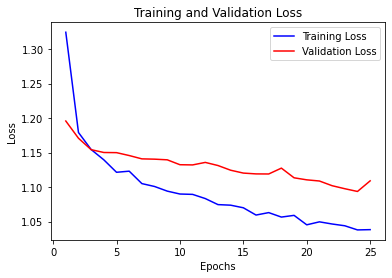

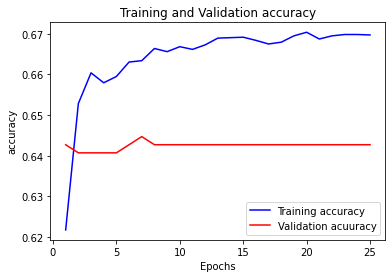

In [17]:
plot_val_loss(history4)
GRU4.save("GRU_regularization_SGD.h5")

In [18]:
# Model with 2 GRU and 2 Dense with regularization with optimizer Adagrad:-(Dropout layers and L2 regularizer)
GRU5 = Sequential()
GRU5.add(GRU(32,input_shape = (9013,375),return_sequences = True,kernel_regularizer = regularizers.l2(0.0001)))
GRU5.add(Dropout(0.25))
GRU5.add(GRU(32,kernel_regularizer = regularizers.l2(0.0001)))
GRU5.add(Flatten())
GRU5.add(Dense(16,activation = 'relu',kernel_regularizer = regularizers.l2(0.0001)))
GRU5.add(Dropout(0.25))
GRU5.add(Dense(7,activation = 'softmax',name = 'Output'))
GRU5.summary()
#compile the model
GRU5.compile(optimizer = 'adagrad' , loss = "categorical_crossentropy", metrics=["accuracy"])
# Fit the model
epochs = 25
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=4)
history5 = GRU5.fit(X_train,y_train,epochs = epochs,validation_data = (X_val,y_val),
                          batch_size = 128,callbacks = [callbacks])
model_evaluate(GRU5)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 9013, 32)          39264     
_________________________________________________________________
dropout_6 (Dropout)          (None, 9013, 32)          0         
_________________________________________________________________
gru_9 (GRU)                  (None, 32)                6336      
_________________________________________________________________
flatten_4 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
Output (Dense)               (None, 7)                

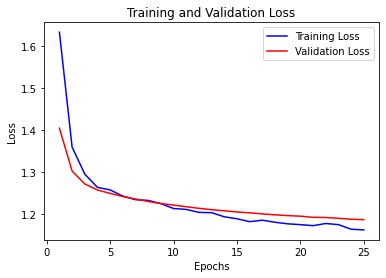

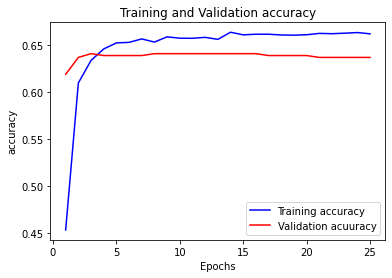

In [19]:
plot_val_loss(history5)
GRU5.save("GRU_regularization_adagard.h5")

In [20]:
# Model with 2 LSTM and 2 Dense without regularization and adam optimizer:-
LSTM1 = Sequential()
LSTM1.add(LSTM(32,input_shape = (9013,375),return_sequences = True))
LSTM1.add(LSTM(32))
LSTM1.add(Flatten())
LSTM1.add(Dense(16,activation = 'relu'))
LSTM1.add(Dense(7,activation = 'softmax',name = 'Output'))
LSTM1.summary()
#compile the model
LSTM1.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])
# Fit the model
epochs = 25
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=2)
history_ls_1 = LSTM1.fit(X_train,y_train,epochs = epochs,validation_data = (X_val,y_val),
                          batch_size = 128,callbacks = [callbacks])
model_evaluate(LSTM1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9013, 32)          52224     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
flatten_5 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
Output (Dense)               (None, 7)                 119       
Total params: 61,191
Trainable params: 61,191
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
71/71 [==============================] - 4s 32ms/step - loss: 1.1794 - accuracy: 0.6597 - val_loss: 1.106

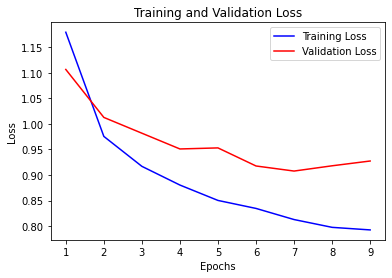

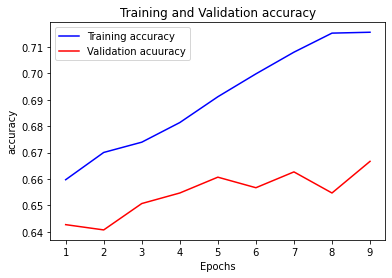

In [21]:
plot_val_loss(history_ls_1)
LSTM1.save("LSTM_Non_regularization_adam.h5")

In [22]:
# Model with 2 LSTM and 2 Dense with regularization and Adam optimizer:-
LSTM2 = Sequential()
LSTM2.add(LSTM(32,input_shape = (9013,375),return_sequences = True,kernel_regularizer = regularizers.l2(0.0001)))
LSTM2.add(Dropout(0.25))
LSTM2.add(LSTM(32,kernel_regularizer = regularizers.l2(0.0001)))
LSTM2.add(Dropout(0.25))
LSTM2.add(Flatten())
LSTM2.add(Dense(16,activation = 'relu',kernel_regularizer = regularizers.l2(0.0001)))
LSTM2.add(Dropout(0.25))
LSTM2.add(Dense(7,activation = 'softmax',name = 'Output'))
LSTM2.summary()
#compile the model
LSTM2.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])
# Fit the model
epochs = 25
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=4)
history_ls_2 = LSTM2.fit(X_train,y_train,epochs = epochs,validation_data = (X_val,y_val),
                          batch_size = 128,callbacks = [callbacks])
model_evaluate(LSTM2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 9013, 32)          52224     
_________________________________________________________________
dropout_8 (Dropout)          (None, 9013, 32)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)               

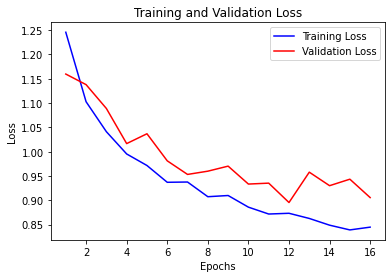

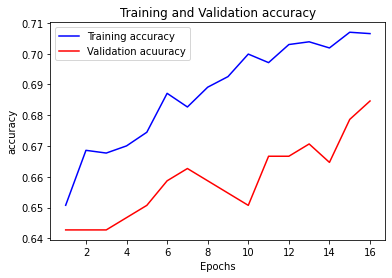

In [23]:
plot_val_loss(history_ls_2)
LSTM2.save("LSTM_regularization_adam.h5")

In [24]:
# Model with 2 LSTM and 2 Dense with regularization and rmsprop optimizer:-
LSTM3 = Sequential()
LSTM3.add(LSTM(32,input_shape = (9013,375),return_sequences = True,kernel_regularizer = regularizers.l2(0.0001)))
LSTM3.add(Dropout(0.25))
LSTM3.add(LSTM(32,kernel_regularizer = regularizers.l2(0.0001)))
LSTM3.add(Dropout(0.25))
LSTM3.add(Flatten())
LSTM3.add(Dense(16,activation = 'relu',kernel_regularizer = regularizers.l2(0.0001)))
LSTM3.add(Dropout(0.25))
LSTM3.add(Dense(7,activation = 'softmax',name = 'Output'))
LSTM3.summary()
#compile the model
LSTM3.compile(optimizer = 'rmsprop' , loss = "categorical_crossentropy", metrics=["accuracy"])
# Fit the model
epochs = 25
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=4)
history_ls_3 = LSTM3.fit(X_train,y_train,epochs = epochs,validation_data = (X_val,y_val),
                          batch_size = 128,callbacks = [callbacks])
model_evaluate(LSTM3)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 9013, 32)          52224     
_________________________________________________________________
dropout_11 (Dropout)         (None, 9013, 32)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)               

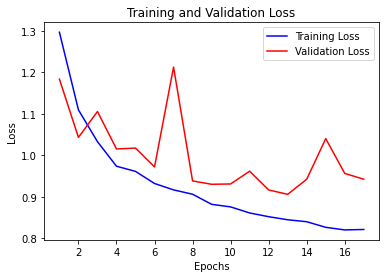

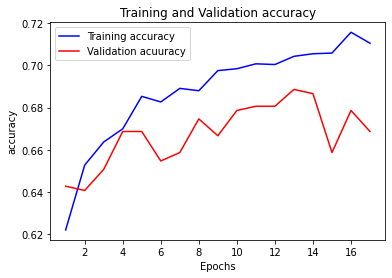

In [25]:
plot_val_loss(history_ls_3)
LSTM3.save("LSTM_regularization_rmsprop.h5")

In [26]:
# Model with 2 LSTM and 2 Dense with regularization and SGD optimizer:-
LSTM4 = Sequential()
LSTM4.add(LSTM(32,input_shape = (9013,375),return_sequences = True,kernel_regularizer = regularizers.l2(0.0001)))
LSTM4.add(Dropout(0.25))
LSTM4.add(LSTM(32,kernel_regularizer = regularizers.l2(0.0001)))
LSTM4.add(Dropout(0.25))
LSTM4.add(Flatten())
LSTM4.add(Dense(16,activation = 'relu',kernel_regularizer = regularizers.l2(0.0001)))
LSTM4.add(Dropout(0.25))
LSTM4.add(Dense(7,activation = 'softmax',name = 'Output'))
LSTM4.summary()
#compile the model
LSTM4.compile(optimizer = 'sgd' , loss = "categorical_crossentropy", metrics=["accuracy"])
# Fit the model
epochs = 25
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=4)
history_ls_4 = LSTM4.fit(X_train,y_train,epochs = epochs,validation_data = (X_val,y_val),
                          batch_size = 128,callbacks = [callbacks])
model_evaluate(LSTM4)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 9013, 32)          52224     
_________________________________________________________________
dropout_14 (Dropout)         (None, 9013, 32)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_16 (Dropout)         (None, 16)               

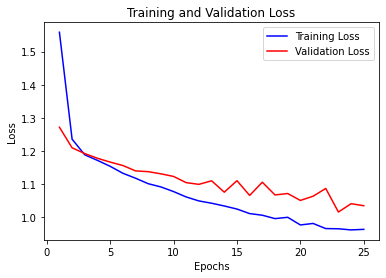

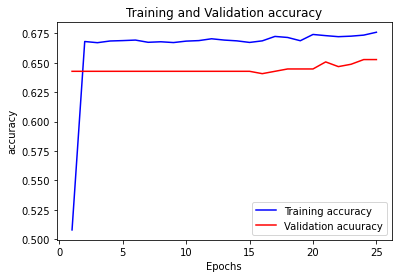

In [27]:
plot_val_loss(history_ls_4)
LSTM4.save("LSTM_regularization_sgd.h5")

In [28]:
# Model with 2 LSTM and 2 Dense with regularization and Adagrad optimizer:-
LSTM5 = Sequential()
LSTM5.add(LSTM(32,input_shape = (9013,375),return_sequences = True,kernel_regularizer = regularizers.l2(0.0001)))
LSTM5.add(Dropout(0.25))
LSTM5.add(LSTM(32,kernel_regularizer = regularizers.l2(0.0001)))
LSTM5.add(Dropout(0.25))
LSTM5.add(Flatten())
LSTM5.add(Dense(16,activation = 'relu',kernel_regularizer = regularizers.l2(0.0001)))
LSTM5.add(Dropout(0.25))
LSTM5.add(Dense(7,activation = 'softmax',name = 'Output'))
LSTM5.summary()
#compile the model
LSTM5.compile(optimizer = 'adagrad' , loss = "categorical_crossentropy", metrics=["accuracy"])
# Fit the model
epochs = 25
callbacks = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=4)
history_ls_2 = LSTM5.fit(X_train,y_train,epochs = epochs,validation_data = (X_val,y_val),
                          batch_size = 128,callbacks = [callbacks])
model_evaluate(LSTM5)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 9013, 32)          52224     
_________________________________________________________________
dropout_17 (Dropout)         (None, 9013, 32)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_19 (Dropout)         (None, 16)               

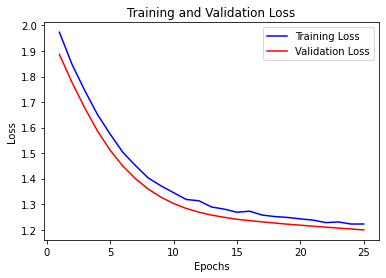

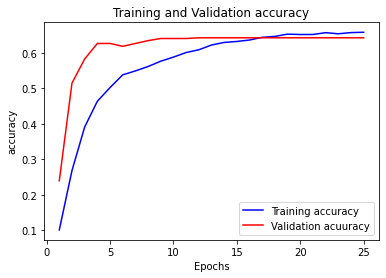

In [29]:
plot_val_loss(history_ls_2)
LSTM5.save("LSTM_regularization_adagrad.h5")

Comparision table of models without regularization:-

$$
\begin{bmatrix}
    \hline
    \mathtt{Model} & \mathtt{test~accuracy} & \mathtt{test~loss} \\
    \hline 
    LSTM & 0.7425 & 0.746 \\  
    GRU & 0.7305 & 0.728 \\ 
    \hline
\end{bmatrix}
$$

Comparision table of various optimizers for GRU with regularization:-


$$
\begin{bmatrix}
    \hline
    \mathtt{optimizer} & \mathtt{test~accuracy} & \mathtt{test~loss} \\
    \hline 
    rmsprop & 0.7325 & 0.762 \\  
    sgd & 0.6926 & 0.915 \\ 
    adam & 0.7225 & 0.749 \\
    adagrad & 0.6926 & 1.013 \\ 
    \hline
\end{bmatrix}
$$

Comparision table of various optimizers for LSTM with regularization:-

$$
\begin{bmatrix}
    \hline
    \mathtt{optimizer} & \mathtt{test~accuracy} & \mathtt{test~loss} \\
    \hline 
    rmsprop & 0.7385 & 0.785 \\  
    sgd & 0.6926 & 0.870 \\ 
    adam & 0.7385 & 0.776 \\
    adagrad & 0.6946 & 1.044 \\ 
    \hline
\end{bmatrix}
$$